# Optimization of Rose Petal Placements on Sheet Metal

This approach uses a basic packing problem application, with a greedy placement algorithm, in order to optimize how many shapes I can cut out of my stock material in order to make my metal roses. At the moment we won't consider rectangle rotation in order to optimize the placement and will assume that the star shape used for the bottom of the rose is rectangular, where the rectangle is a bounding box for the shape, assuming it was standing with its point facing up (this is a TODO, and I plan on implementing these changes so that these two instances will be considered in the near future)

*Note:* At the moment, we're not optimizing for scrap metal, which might be an important consideration depending on the nature of the project

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point, box
from shapely.affinity import translate
import random

%load_ext jupyter_black

How many roses do you want to make and what are the dimensions of your sheet metal? <br>
*Note*: Gauge of the stock is irrelevant

In [2]:
# Number of whole roses.
# Fractions can be added in in the cell below
num_of_roses = 29

# Stock dimensions
# At the moment, orientation does matter (if not square)
SHEET_WIDTH = 24
SHEET_HEIGHT = 24

Sometimes I like to have additional pieces cut out, just because I know I plan on experimenting with a certain shape. In case you know you want specific additional pieces that don't add up to an entire rose, you can add them in here. If no additional piece is required, set them to `0`

In [3]:
additional_large_circle = 0
additional_medium_circle = 0
additional_small_circle = 0
additional_small_rectangle = 0
additional_large_rectangle = 0

#### Define the functions that are doing the calculation
For my current rose design, I am using two large petal circles, one medium, one small, as well as one star shape for the bottom, and two leaves. This means that for the "Large Circle" (large petals) and "Leaves", the `num_of_roses` will be multiplied by 2 in order to get the correct count

In [4]:
shapes_to_place = [
    (
        "Large Circle",
        num_of_roses * 2 + additional_large_circle,
        lambda: Point(0, 0).buffer(3.35 / 2),
    ),
    (
        "Medium Circle",
        num_of_roses + additional_medium_circle,
        lambda: Point(0, 0).buffer(3 / 2),
    ),
    (
        "Small Circle",
        num_of_roses + additional_small_circle,
        lambda: Point(0, 0).buffer(2.5 / 2),
    ),
    (
        "Small Rectangle",
        num_of_roses * 2 + additional_small_rectangle,
        lambda: box(0, 0, 1, 2.1),
    ),
    (
        "Large Rectangle",
        num_of_roses + additional_large_rectangle,
        lambda: box(0, 0, 2.8, 2.7),
    ),
]

sheets = [[]]


def can_place(new_shape, placed_shapes):
    return all(not new_shape.intersects(other[0]) for other in placed_shapes)


def place_shapes_on_sheets():
    """
    `margin` is added so there is a small gap between shapes in order to avoid overlap.
    This will make sure that any error with the laser with one shape doesn't damage the neighboring shapes.
    """
    margin: float = 0.05
    for label, count, shape_fn in shapes_to_place:
        print(f"Placing: {label}")
        shape_sample = shape_fn()
        minx, miny, maxx, maxy = shape_sample.bounds
        shape_width = maxx - minx
        shape_height = maxy - miny

        placed = 0
        sheet_idx = 0

        while placed < count:
            if sheet_idx >= len(sheets):
                sheets.append([])

            sheet = sheets[sheet_idx]
            found_spot = False

            for x in range(
                0, int((SHEET_WIDTH - shape_width) // (shape_width + margin)) + 1
            ):
                for y in range(
                    0, int((SHEET_HEIGHT - shape_height) // (shape_height + margin)) + 1
                ):
                    x_pos = x * (shape_width + margin)
                    y_pos = y * (shape_height + margin)

                    shape = translate(
                        shape_sample, xoff=x_pos - minx, yoff=y_pos - miny
                    )

                    if not box(0, 0, SHEET_WIDTH, SHEET_HEIGHT).contains(shape):
                        continue

                    if all(not shape.intersects(existing[0]) for existing in sheet):
                        sheet.append((shape, label))
                        placed += 1
                        found_spot = True
                        break
                if found_spot:
                    break

            if not found_spot:
                sheet_idx += 1

Placing: Large Circle
Placing: Medium Circle
Placing: Small Circle
Placing: Small Rectangle
Placing: Large Rectangle


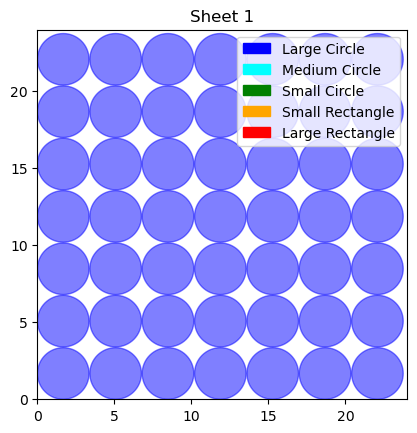

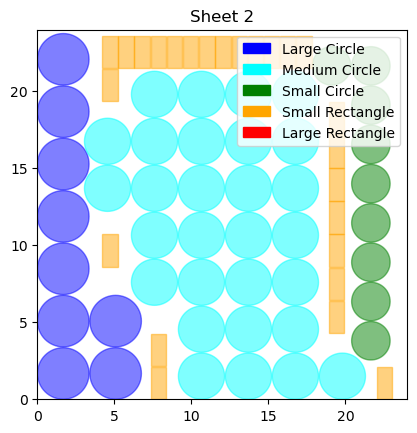

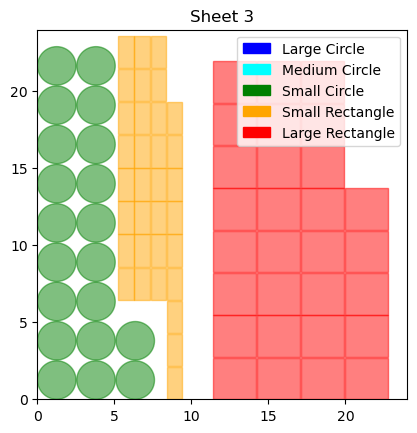

In [5]:
def plot_sheets():
    label_colors = {
        "Large Circle": "blue",
        "Medium Circle": "cyan",
        "Small Circle": "green",
        "Small Rectangle": "orange",
        "Large Rectangle": "red",
    }

    for i, sheet in enumerate(sheets):
        fig, ax = plt.subplots()
        ax.set_xlim(0, SHEET_WIDTH)
        ax.set_ylim(0, SHEET_HEIGHT)
        ax.set_title(f"Sheet {i + 1}")
        ax.set_aspect("equal")

        added_labels = set()

        for shape, label in sheet:
            color = label_colors[label]
            x, y = shape.exterior.xy
            ax.fill(x, y, alpha=0.5, color=color)

        patches = [
            mpatches.Patch(color=color, label=label)
            for label, color in label_colors.items()
        ]
        ax.legend(handles=patches, loc="upper right")
        plt.show()


place_shapes_on_sheets()
plot_sheets()

Additional TODO: It would also be possible to use actual shapes instead of approximate ones in order to calculate the placement, and then be able to export the image as a DXF file so it can be used directly with the CNC. I still need a bit more hands on experience with the CNC before I figure out if that's a good approach, so for now I will continue to use the graph as a guide, and manually place the shapes in that order for cutting